In [2]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
import math
plt.rcParams['axes.grid'] = True
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['axes.labelsize'] = 20
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath, amsfonts}')
plt.tight_layout()

plt.rc('font', size=20)
plt.rc('lines', linewidth=2)
plt.rc('legend', fontsize=18, frameon=False)
plt.rc('xtick', labelsize=14, direction='in')
plt.rc('ytick', labelsize=14, direction='in')
plt.rc('figure', figsize=(6, 4))


<Figure size 600x450 with 0 Axes>

In [3]:
from scipy import special
i = 10
H = special.hermite(i, monic=True)
H_prime = special.hermitenorm(i)

print('probabilist', H(1.))
print('physicist', H_prime(1. / np.sqrt(2.)) / np.sqrt(np.power(2, i)))

# Use monic = False for all the hermite

probabilist 8.031249999999993
physicist 22.061523437499993


In [4]:
## verify the kernel

from scipy import special
from sklearn.gaussian_process.kernels import RBF
l = 1.0
kernel = 1.0 * RBF(l)
x = np.array([[1.]])
y = np.array([[2.]])
K = kernel(x, y)
print('Gaussian kernel value:', K)

alpha =  1.0

hermite_order = 20
sum = 0
rho_list = []
epsilon = 1 / (np.sqrt(2) * l)
beta = (1 + (2 * epsilon / alpha) ** 2) ** 0.25
delta = (alpha ** 2) * (beta ** 2 - 1) / 2

from tqdm import tqdm
for i in tqdm(range(hermite_order)):
    H = special.hermite(i, monic=False)
    phi_x = np.sqrt(beta / math.factorial(i)) * np.exp(-(delta) * (x ** 2)) * H(alpha * beta * x) / np.sqrt(2 ** i)
    phi_y = np.sqrt(beta / math.factorial(i)) * np.exp(-(delta) * (y ** 2)) * H(alpha * beta * y) / np.sqrt(2 ** i)
    rho = alpha / np.sqrt(alpha ** 2 + delta + epsilon ** 2) * np.power( epsilon ** 2 / (alpha ** 2 + delta + epsilon ** 2), i)
    rho_list.append(rho)
    sum += rho * phi_x * phi_y

print('Gaussian kernel value with mercer decomposition',sum)

lmbda_array = np.array(rho_list)


Gaussian kernel value: [[0.60653066]]


100%|██████████| 20/20 [00:00<00:00, 6356.93it/s]

Gaussian kernel value with mercer decomposition [[0.60653066]]


In [5]:
#compute integral of hermite with respect to a Gaussian N(0, )

def integrate_hermite_gaussian(n, alpha, p):
    # \int H_n( c x) exp(-p x^2) dx
    if n % 2 != 0:
        return 0
    else:
        H = special.hermite(n)
        sigma = 1 / np.sqrt(2 * p)
    return np.sqrt(2 * np.pi) * sigma * np.power(1 - 2 * (alpha ** 2) * (sigma ** 2), int(n/2)) * H(0)

hermite_order_ = 2
c = 2.0
scale = 2.0
grid = np.random.normal(loc=0.0, scale=scale, size=1000000)
# numerical integration
H = special.hermite(hermite_order_)
print('numerical integration:', H(grid * c).mean())
# analytical integration
print('analytical integration:', integrate_hermite_gaussian(hermite_order_, c, 1. / (2 * scale ** 2) ) / ( np.sqrt(2 * np.pi) * scale))

numerical integration: 61.918970082290784
analytical integration: 62.0


In [6]:
# witness function for MMD

# empirical witness
scale_x, scale_y = 1.0, 2.0
x_samples = np.random.normal(loc=0.0, scale=scale_x, size=1000).reshape(-1, 1)
y_samples = np.random.normal(loc=0.0, scale=scale_y, size=1000).reshape(-1, 1)
z = np.array([[0.5]])
h = kernel(z, x_samples).mean() - kernel(z, y_samples).mean()
print('empirical witness:', h)
# analytical witness


sum = 0
for i in range(hermite_order):
    H = special.hermite(i)
    coeff = np.sqrt(beta / np.math.factorial(i)) / np.sqrt(2 ** i)
    emd_x = coeff * integrate_hermite_gaussian(i, alpha * beta, delta + 1. / (2 * scale_x ** 2)) / ( np.sqrt(2 * np.pi) * scale_x)
    emd_y = coeff * integrate_hermite_gaussian(i, alpha * beta, delta + 1. / (2 * scale_y ** 2)) / ( np.sqrt(2 * np.pi) * scale_y)
    phi_z = coeff * np.exp(-(delta) * (z ** 2)) * H(alpha * beta * z)
    sum += rho_list[i] * (emd_x - emd_y) * phi_z

print('anaytic witness:', sum)

empirical witness: 0.2054425037959931
anaytic witness: [[0.22809349]]


/tmp/ipykernel_188004/3210351800.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  coeff = np.sqrt(beta / np.math.factorial(i)) / np.sqrt(2 ** i)


In [7]:
# witness function for DrMMD
lmbda = 0.1

# empirical witness
scale_x, scale_y = 1.0, 2.0
x_samples = np.random.normal(loc=0.0, scale=scale_x, size=1000).reshape(-1, 1)
y_samples = np.random.normal(loc=0.0, scale=scale_y, size=1000).reshape(-1, 1)
z = np.array([[0.5]])
K_zY = kernel(z, y_samples)
K_zX = kernel(z, x_samples)
K_XX = kernel(x_samples, x_samples)
K_XY = kernel(x_samples, y_samples)

K_XX_inv = np.linalg.inv(K_XX + x_samples.shape[0] * lmbda * np.eye(K_XX.shape[0]))
part1 = - K_zY.mean(axis=1) + K_zX.mean(axis=1)
part2 = (K_zX @ K_XX_inv @ K_XY).mean(axis=1)
part3 = - (K_zX @ K_XX_inv @ K_XX).mean(axis=1)
h = (part1 + part2 + part3).squeeze() / lmbda * 2 * (1 + lmbda)
print('empirical witness:', h)


# analytical witness
sum = 0
for i in range(hermite_order):
    H = special.hermite(i)
    coeff = np.sqrt(beta / np.math.factorial(i)) / np.sqrt(2 ** i)
    emd_x = coeff * integrate_hermite_gaussian(i, alpha * beta, delta + 1. / (2 * scale_x ** 2)) / ( np.sqrt(2 * np.pi) * scale_x)
    emd_y = coeff * integrate_hermite_gaussian(i, alpha * beta, delta + 1. / (2 * scale_y ** 2)) / ( np.sqrt(2 * np.pi) * scale_y)
    phi_z = coeff * np.exp(-(delta) * (z ** 2)) * H(alpha * beta * z)
    sum += 2 * (1+lmbda) * (rho_list[i] / (rho_list[i] + lmbda) ) * (emd_x - emd_y) * phi_z

print('anaytic witness:', sum)

empirical witness: 0.8789955974147338
anaytic witness: [[0.65562594]]


/tmp/ipykernel_188004/445368671.py:26: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  coeff = np.sqrt(beta / np.math.factorial(i)) / np.sqrt(2 ** i)


In [8]:
# velocity field for DrMMD
import abc
import jax.numpy as jnp
from flax import struct
from jax import vmap


def _rescale(x, scale) :
    return x / scale
def _l2_norm_squared(x) :
    return jnp.sum(jnp.square(x))


class base_kernel(struct.PyTreeNode, metaclass=abc.ABCMeta):
    @abc.abstractmethod
    def __call__(self, x, y) :
        raise NotImplementedError

    def make_distance_matrix(self, X, Y) :
        return vmap(vmap(type(self).__call__, (None, None, 0)), (None, 0, None))(
            self, X, Y
        )


class gaussian_kernel(base_kernel):
    sigma: float

    def __call__(self, x, y) :
        return jnp.exp(-0.5 * _l2_norm_squared(_rescale(x - y, self.sigma)))

import time
lmbda = 1.0
scale_x, scale_y = 1.0, 2.0
# Set a seed for reproducibility
key = jax.random.PRNGKey(int(time.time() * 10000))
x_samples_jax = jax.random.normal(key, shape=(1000,)) * scale_x
key, _ = jax.random.split(key)
y_samples_jax = jax.random.normal(key, shape=(100,)) * scale_y
z = jnp.array([[2.0]])
jax_kernel = gaussian_kernel(sigma=l)

#empirical velocity field
def h(z):
    K_zY = jax_kernel.make_distance_matrix(z, y_samples_jax)
    K_zX = jax_kernel.make_distance_matrix(z, x_samples_jax)
    K_XX = jax_kernel.make_distance_matrix(x_samples_jax, x_samples_jax)
    K_XY = jax_kernel.make_distance_matrix(x_samples_jax, y_samples_jax)

    K_XX_inv = jnp.linalg.inv(K_XX + x_samples_jax.shape[0] * lmbda * jnp.eye(K_XX.shape[0]))
    part1 = - K_zY.mean(axis=1) + K_zX.mean(axis=1)
    part2 = (K_zX @ K_XX_inv @ K_XY).mean(axis=1)
    part3 = - (K_zX @ K_XX_inv @ K_XX).mean(axis=1)
    return (part1 + part2 + part3).squeeze() / lmbda * 2 * (1 + lmbda)

print('empirical velocity field:', jax.grad(h)(z))

x_samples = np.array(x_samples_jax).reshape(-1, 1)
y_samples = np.array(y_samples_jax).reshape(-1, 1)

# analytical witness
sum = 0
for i in range(1, hermite_order):
    H = special.hermite(i)
    H_prime = special.hermite(i - 1)
    coeff = np.sqrt(beta / np.math.factorial(i)) / np.sqrt(2 ** i)
    emd_x = coeff * integrate_hermite_gaussian(i, alpha * beta, delta + 1. / (2 * scale_x ** 2)) / ( np.sqrt(2 * np.pi) * scale_x)
    emd_y = coeff * integrate_hermite_gaussian(i, alpha * beta, delta + 1. / (2 * scale_y ** 2)) / ( np.sqrt(2 * np.pi) * scale_y)
    grad_phi_z_1 = coeff * np.exp(-(delta) * (z ** 2)) * (2 * i) * H_prime(alpha * beta * z) * alpha * beta
    grad_phi_z_2 = coeff * np.exp(-(delta) * (z ** 2)) * (-2 * delta * z) * H(alpha * beta * z)
    sum += 2 * (1+lmbda) * (rho_list[i] / (rho_list[i] + lmbda) ) * (emd_x - emd_y) * (grad_phi_z_1 + grad_phi_z_2)

print('anaytic velocity field:', sum)

empirical velocity field: [[-0.33440357]]
anaytic velocity field: [[-0.23106459]]


/tmp/ipykernel_188004/1354206708.py:65: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  coeff = np.sqrt(beta / np.math.factorial(i)) / np.sqrt(2 ** i)


In [17]:
from tqdm import tqdm

q_0 = 1.0
s_0 = q_0 / 2
particle_num = 1000
lmbda = 0.1

np.random.seed(0)
y = np.random.normal(loc=0.0, scale=np.sqrt(s_0), size=10).reshape(-1, 1)
x = np.random.normal(loc=0.0, scale=np.sqrt(q_0), size=10).reshape(-1, 1)

gamma = 0.001

scale_x = np.sqrt(q_0)

def kl_divergence_gaussian(sigma1, sigma2):
    kl_div = np.log(sigma2 / sigma1 + 1e-10) + (sigma1**2 / (2 * sigma2**2)) - 0.5
    return kl_div


def chi2_divergence_gaussian(sigma1, sigma2):
    chi2_div = sigma2**2 / sigma1 / np.sqrt(np.abs(2 * sigma2**2 - sigma1**2 + 0.001)) - 1
    return chi2_div

iter_num = 100
kl_array = np.zeros(iter_num)
lmbda_array = np.zeros(iter_num)

chi2_0 = chi2_divergence_gaussian(np.std(y), scale_x)


# adaptive lambda
for iter in tqdm(range(iter_num)):
    scale_y = np.std(y)
    kl_array[iter] = kl_divergence_gaussian(np.std(y), scale_x)
    lmbda_array[iter] = lmbda

    if iter % 100 == 0:
        # print(r'covariance of $\mu_n$', scale_y ** 2)
        pass
    for j, y_particle in enumerate(y):
        z = y_particle
        sum = 0
        for i in range(1, hermite_order):
            H = special.hermite(i)
            H_prime = special.hermite(i - 1)
            coeff = np.sqrt(beta / np.math.factorial(i)) / np.sqrt(2 ** i)
            emd_x = coeff * integrate_hermite_gaussian(i, alpha * beta, delta + 1. / (2 * scale_x ** 2)) / ( np.sqrt(2 * np.pi) * scale_x)
            emd_y = coeff * integrate_hermite_gaussian(i, alpha * beta, delta + 1. / (2 * scale_y ** 2)) / ( np.sqrt(2 * np.pi) * scale_y)
            grad_phi_z_1 = coeff * np.exp(-(delta) * (z ** 2)) * (2 * i) * H_prime(alpha * beta * z) * alpha * beta
            grad_phi_z_2 = coeff * np.exp(-(delta) * (z ** 2)) * (-2 * delta * z) * H(alpha * beta * z)
            sum += 2 * (1+lmbda) * (rho_list[i] / (rho_list[i] + lmbda) ) * (emd_x - emd_y) * (grad_phi_z_1 + grad_phi_z_2)
        y[j] = y_particle + gamma * sum
    # update lmabda
    chi2_curr = chi2_divergence_gaussian(np.std(y), scale_x)
    ratio = chi2_curr / chi2_0
    lmbda = max(lmbda * ratio, 1e-3)
        
lmbda_array_adaptive = lmbda_array
kl_array_adaptive = kl_array

  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_188004/835287424.py:47: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  coeff = np.sqrt(beta / np.math.factorial(i)) / np.sqrt(2 ** i)
100%|██████████| 100/100 [00:02<00:00, 42.93it/s]


In [18]:
from tqdm import tqdm

q_0 = 1.0
s_0 = q_0 / 2
particle_num = 1000
lmbda = 0.1

np.random.seed(0)
y = np.random.normal(loc=0.0, scale=np.sqrt(s_0), size=10).reshape(-1, 1)
x = np.random.normal(loc=0.0, scale=np.sqrt(q_0), size=10).reshape(-1, 1)

gamma = 0.01

scale_x = np.sqrt(q_0)

def kl_divergence_gaussian(sigma1, sigma2):
    kl_div = np.log(sigma2 / sigma1 + 1e-6) + (sigma1**2 / (2 * sigma2**2)) - 0.5
    return kl_div


def chi2_divergence_gaussian(sigma1, sigma2):
    chi2_div = sigma2**2 / sigma1 / np.sqrt(np.abs(2 * sigma2**2 - sigma1**2 + 0.001)) - 1
    return chi2_div

iter_num = 100
kl_array = np.zeros(iter_num)
lmbda_array = np.zeros(iter_num)

chi2_0 = chi2_divergence_gaussian(np.std(y), scale_x)


# fixed lambda
for iter in tqdm(range(iter_num)):
    scale_y = np.std(y)
    kl_array[iter] = kl_divergence_gaussian(np.std(y), scale_x)
    lmbda_array[iter] = lmbda

    if iter % 100 == 0:
        # print(r'covariance of $\mu_n$', scale_y ** 2)
        pass
    for j, y_particle in enumerate(y):
        z = y_particle
        sum = 0
        for i in range(1, hermite_order):
            H = special.hermite(i)
            H_prime = special.hermite(i - 1)
            coeff = np.sqrt(beta / np.math.factorial(i)) / np.sqrt(2 ** i)
            emd_x = coeff * integrate_hermite_gaussian(i, alpha * beta, delta + 1. / (2 * scale_x ** 2)) / ( np.sqrt(2 * np.pi) * scale_x)
            emd_y = coeff * integrate_hermite_gaussian(i, alpha * beta, delta + 1. / (2 * scale_y ** 2)) / ( np.sqrt(2 * np.pi) * scale_y)
            grad_phi_z_1 = coeff * np.exp(-(delta) * (z ** 2)) * (2 * i) * H_prime(alpha * beta * z) * alpha * beta
            grad_phi_z_2 = coeff * np.exp(-(delta) * (z ** 2)) * (-2 * delta * z) * H(alpha * beta * z)
            sum += 2 * (1+lmbda) * (rho_list[i] / (rho_list[i] + lmbda) ) * (emd_x - emd_y) * (grad_phi_z_1 + grad_phi_z_2)
        y[j] = y_particle + gamma * sum

kl_array_fixed = kl_array

  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_188004/4163827155.py:47: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  coeff = np.sqrt(beta / np.math.factorial(i)) / np.sqrt(2 ** i)
100%|██████████| 100/100 [00:02<00:00, 43.06it/s]


<Figure size 600x450 with 0 Axes>

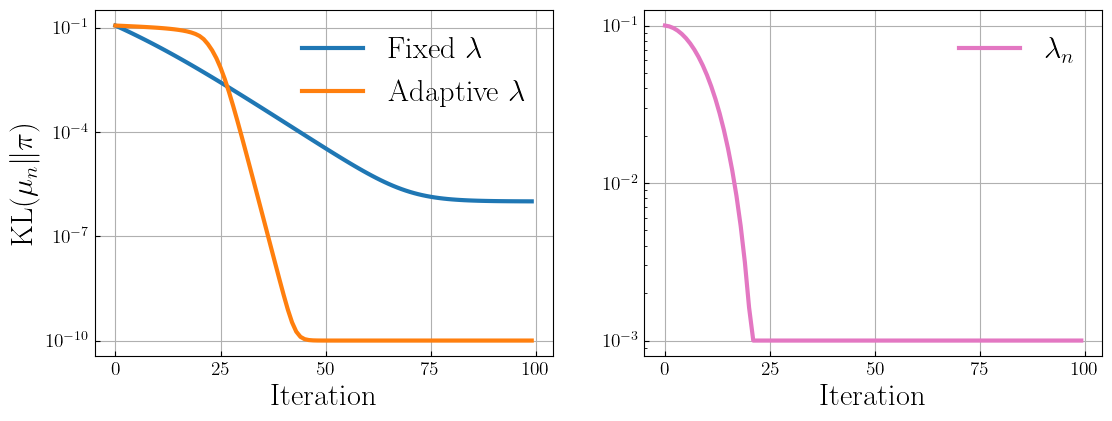

In [23]:
import matplotlib.pyplot as plt
plt.rcParams['axes.grid'] = True
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['axes.labelsize'] = 22
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath, amsfonts}')
plt.tight_layout()

plt.rc('font', size=22)
plt.rc('lines', linewidth=3)
plt.rc('legend', fontsize=22, frameon=False)
plt.rc('xtick', labelsize=14, direction='in')
plt.rc('ytick', labelsize=14, direction='in')
plt.rc('figure', figsize=(6, 4.5))

fig, axs = plt.subplots(1, 2, figsize=(13, 4.5))
axs[0].plot(kl_array_fixed, label=r'Fixed $\lambda$')
axs[0].plot(kl_array_adaptive, label=r'Adaptive $\lambda$')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel(r'$\text{KL}(\mu_n \| \pi)$')
axs[0].set_yscale('log')
axs[0].legend()
axs[0].set_xticks([0, 25, 50, 75, 100])
axs[0].set_yticks([1e-1, 1e-4, 1e-7, 1e-10])
colors = plt.get_cmap('tab10')

axs[1].plot(lmbda_array_adaptive, color=colors(6), label=r'$\lambda_n$')
axs[1].set_xlabel('Iteration')
# axs[1].set_ylabel(r'$\lambda_n$')
axs[1].set_xticks([0, 25, 50, 75, 100])
axs[1].set_yscale('log')
axs[1].legend()
plt.subplots_adjust(hspace=2.0) 
plt.savefig(f'/home/zongchen/drmmd/figures_new/KL.pdf')
plt.show()

<Figure size 600x450 with 0 Axes>

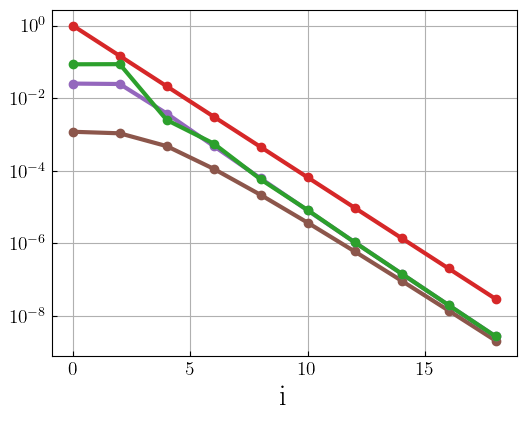

In [12]:
# Verify the eigenvalue decay of the density ratio
import numpy as np
import math
import scipy
hermite_order = 10
import matplotlib.pyplot as plt
plt.rcParams['axes.grid'] = True
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['axes.labelsize'] = 22
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath, amsfonts}')
plt.tight_layout()

plt.rc('font', size=22)
plt.rc('lines', linewidth=3)
plt.rc('legend', fontsize=22, frameon=False)
plt.rc('xtick', labelsize=14, direction='in')
plt.rc('ytick', labelsize=14, direction='in')
plt.rc('figure', figsize=(6, 4.5))

i_array = np.arange(hermite_order) * 2
q_0 = 1.0
beta = (1 + (4 * q_0)) ** 0.25
delta = (beta ** 2 - 1) / (4 * q_0)
kernel_eig = np.power(0.5 / (0.5 + delta + 1 / (2 * q_0) ), i_array)

eig_dict = {1.1: None,
            1.5: None,
            2.0: None
            }
colors = plt.get_cmap('tab10')
eig_color_dict = {1.1: colors(5),
                1.5: colors(4),
                2.0: colors(2)
                }
for r in eig_dict.keys():
    s_t = q_0 / r
    dense_ratio_eig_1 = scipy.special.factorial(i_array) / (scipy.special.factorial(i_array / 2) ** 2) / np.power(2, i_array)
    dense_ratio_eig_2 = np.power(1 - beta ** 2 / (2 * q_0) / (delta + 1 / (2 * s_t)), i_array / 2)
    dense_ratio_eig_3 = np.power(1 - beta ** 2 / (2 * q_0) / (delta + 1 / (2 * q_0)), i_array / 2)
    dense_ratio_eig = dense_ratio_eig_1 * (dense_ratio_eig_2 * np.sqrt(0.5 / s_t) -  dense_ratio_eig_3 * np.sqrt(0.5 / q_0)) ** 2
    eig_dict[r] = np.abs(dense_ratio_eig)

fig, ax = plt.subplots(figsize=(6, 4.5))
# plt.grid(False)
plt.plot(i_array, kernel_eig, label=r'$\rho_i$', color = colors(3), marker='o')
for r, dense_ratio_eig in eig_dict.items():
    s = q_0 / r
    plt.plot(i_array, dense_ratio_eig, color=eig_color_dict[r], label=r'$\left\langle \frac{d \mu}{d \pi} - 1, e_i \right\rangle_{L^2(\pi)}$' + f'($s={s}$)', marker='o')
# plt.legend()
ax.set_xticks([0, 5, 10, 15])
plt.yscale('log')
plt.xlabel('i')
plt.savefig(f'/home/zongchen/drmmd/figures_new/eigenvalue_illustrative.pdf')
plt.show()

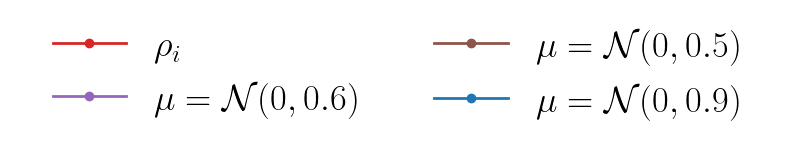

In [13]:
# legend_elements = [plt.Line2D([0], [0], color=colors(3), lw=2, label=r'$\rho_i$', marker='o'),
#                    plt.Line2D([0], [0], color=colors(0), lw=2, label=r'$\left\langle \frac{d \mu}{d \pi} - 1, e_i \right\rangle_{L^2(\pi)}$' + r'($\mu=\mathcal{N}(0, 0.9)$)', marker='o'),
#                    plt.Line2D([0], [0], color=colors(1), lw=2, label=r'$\left\langle \frac{d \mu}{d \pi} - 1, e_i \right\rangle_{L^2(\pi)}$' + r'($\mu=\mathcal{N}(0, 0.6)$)', marker='o'),
#                    plt.Line2D([0], [0], color=colors(2), lw=2, label=r'$\left\langle \frac{d \mu}{d \pi} - 1, e_i \right\rangle_{L^2(\pi)}$' + r'($\mu=\mathcal{N}(0, 0.5)$)', marker='o'),
#                    ]
legend_elements = [plt.Line2D([0], [0], color=colors(3), lw=2, label=r'$\rho_i$', marker='o'),
                   plt.Line2D([0], [0], color=colors(4), lw=2, label=r'$\mu=\mathcal{N}(0, 0.6)$', marker='o'),
                   plt.Line2D([0], [0], color=colors(5), lw=2, label=r'$\mu=\mathcal{N}(0, 0.5)$', marker='o'),
                   plt.Line2D([0], [0], color=colors(0), lw=2, label=r'$\mu=\mathcal{N}(0, 0.9)$', marker='o'),
                   ]
# Create a new figure and axis for the legend
legend_fig, legend_ax = plt.subplots(figsize=(10, 1.7))
legend_ax.set_axis_off()
legend_ax.legend(handles=legend_elements, loc='center', ncol=2, fontsize='large')
plt.savefig(f'/home/zongchen/drmmd/figures_new/legend_eigenvalue.pdf')
 

In [14]:
beta ** 2 / q_0 / (delta + 1 / (2 * q_0))

2.76393202250021

In [15]:
beta ** 2 / q_0 / (delta + 1 / (2 * s_t))

1.7082039324993687